In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint



In [ ]:
drive.mount('/content/drive')

# Configuración de paths y parámetros
img_height, img_width = 224, 224
batch_size = 32
num_classes = 6
input_shape = (img_height, img_width, 3)

# Aumentación de datos
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # Dividir 80% entrenamiento, 20% prueba
)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directorio de tus imágenes organizadas en carpetas (una por cada clase de pH)
data_dir = '/content/drive/MyDrive/ph modificdo'

# Preparar generadores de imágenes para entrenamiento y validación
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)




Found 618 images belonging to 6 classes.
Found 150 images belonging to 6 classes.


In [ ]:
# Cargar el modelo base ResNet50 sin la capa superior (la de clasificación original)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas de ResNet50 para preservar los pesos preentrenados
base_model.trainable = False

# Añadir nuevas capas para la clasificación de pH
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Capa de promedio global
x = Dense(1024, activation='relu')(x)  # Capa totalmente conectada
output = Dense(num_classes, activation='softmax')(x)  # Capa de salida

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compilar el modelo
model.compile(optimizer='adam',  # Optimizador Adam
              loss='categorical_crossentropy',  # Pérdida para clasificación categórica
              metrics=['accuracy'])

# Configuración de checkpoint para guardar el mejor modelo
checkpoint = ModelCheckpoint('ph_classifier.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[checkpoint]
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2069 - loss: 4.7444 - val_accuracy: 0.4600 - val_loss: 1.4254
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 848ms/step - accuracy: 0.4699 - loss: 1.4289 - val_accuracy: 0.5600 - val_loss: 1.2352
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 837ms/step - accuracy: 0.5734 - loss: 1.2077 - val_accuracy: 0.7133 - val_loss: 0.9543
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 864ms/step - accuracy: 0.6594 - loss: 0.9483 - val_accuracy: 0.8133 - val_loss: 0.6618
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 768ms/step - accuracy: 0.7094 - loss: 0.8375 - val_accuracy: 0.7200 - val_loss: 0.7763
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6674 - loss: 0.8322 - val_accuracy: 0.8467 - val_loss: 0.5487
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 868ms/step - accuracy: 0.7866 - loss: 0.6422 - val_accuracy: 0.8800 - val_loss: 0.4162
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 779ms/step - accuracy: 0.8391 - loss: 0.5242 - val_accuracy: 0.8533 - va

In [ ]:
# Guardar el modelo final
model.save("ph_classifierv1.keras")

print("Entrenamiento completado y modelo guardado como 'ph_classifierv1.keras'")

Entrenamiento completado y modelo guardado como 'ph_classifierv1.keras'


In [ ]:
import os
print(os.getcwd())  # Muestra el directorio de trabajo actual

/content


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


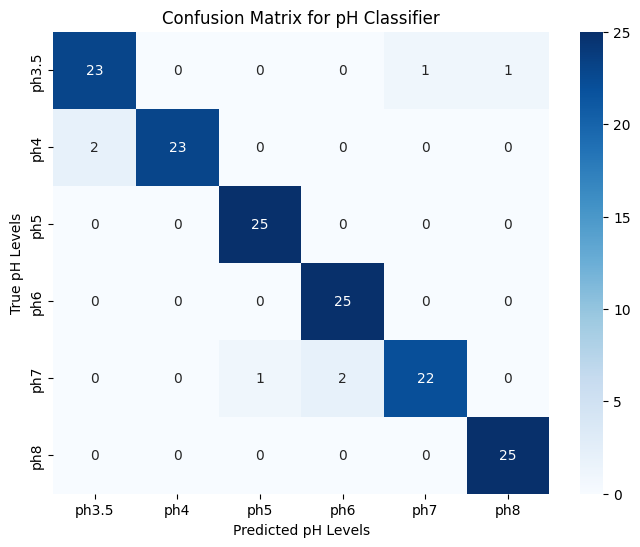

In [ ]:
# Cargar el modelo guardado
model = tf.keras.models.load_model("/content/ph_classifier.keras")

# Obtener las etiquetas verdaderas del generador de validación
val_labels = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())  # Nombres de las clases (niveles de pH)

# Generar predicciones en el conjunto de validación
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Crear la matriz de confusión
conf_matrix = confusion_matrix(val_labels, predicted_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted pH Levels")
plt.ylabel("True pH Levels")
plt.title("Confusion Matrix for pH Classifier")
plt.show()
